In [9]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [10]:
m = 10 # Количество частей файла (скачиваются по порядку. У лича >= 1 части, у сида все m частей)
n, l = 2 * (m + 1), m + 2 # количество видов узлов и возможных взаимодействий между ними

def get_alpha():
    lichers = np.array([m * 2 if i == 0 or i == m else m - i for i in range(m + 1)]) # количество личей с i частями файла
    lichers_ = np.append(np.cumsum(lichers[::-1]
            )[:-1:][::-1], 0) # количество подходящих для лича узлов для передачи файла (для новых клиентов - все личи + сиды)
    alpha = np.append(lichers, lichers_)
    return alpha

lichers = np.array([m * 2 if i == 0 or i == m else m - i for i in range(m + 1)]) # количество личей с i частями файла
lichers_ = np.append(np.cumsum(lichers[::-1]
            )[:-1:][::-1], 0) # количество подходящих для лича узлов для передачи файла (для новых клиентов - все личи + сиды)
alpha = np.append(lichers, lichers_)

lmb = 1
delta = sum(lichers_)
mu = 0.2
phi = ([lmb] +
       [lichers_[i] * lichers[i] / delta for i in range(m)] +
       [mu])

eps = np.array([[0 for i in range(m + 1)] + [0 for i in range(m + 1)]] +
               [[1 if i == j else 0 for i in range(m + 1)] + [1 if i == j else 0 for i in range(m + 1)] for j in range(m)] +
               [[1 if i == m else 0 for i in range(m + 1)] + [0 for i in range(m + 1)]])

p_gamma = np.array([[1 if i == 0 else 0 for i in range(m + 1)] + [0 for i in range(m + 1)]] +
                   [[1 if i == j + 1 else 0 for i in range(m + 1)] + [2 if i == j else 0 for i in range(m + 1)] for j in range(m)] +
                   [[0 for i in range(m + 1)] + [0 for i in range(m + 1)]])

In [11]:
def inverse_exp(random_, coef):
    '''Возвращает значение случайной величины,
    распределённой по экспоненциальному закону,
    соответствующему простейшему Пуассоновскому потоку'''
    if coef == 0:
        return np.finfo(np.float32).max
    return -1/coef * math.log(1 - random_)
    #return 1/coef

tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
for i in range(l):
    tau[i] = inverse_exp(random.random(), phi[i])

def update_tau(tau, ):
    ''' Возвращает матрицу с временами событий на следующем шаге и ближайшее событие
    :param tau: array of trigger times, generated on the previous step
    :return: times array on the next step, next event, time of next event'''
    min_ = np.finfo(np.float32).max
    idx_min = 0

    for k in range(len(tau)):
        if tau[k] == np.finfo(np.float32).max and phi[k] != 0:
            tau[k] = inverse_exp(random.random(), phi[k])
        if tau[k] < min_:
            min_ = tau[k]
            idx_min = k
    tau -= min_
    return tau, idx_min, min_

def update_lichers_(lichers):
    return np.append(np.cumsum(lichers[::-1] 
            )[:-1:][::-1], 0)

def update_phi(alpha):
    phi = np.array([lmb] +
                   [lichers_[i] * lichers[i] / delta for i in range(m)] +
                   [mu])
    phi[~np.all(eps <= alpha, axis=1)] = 0
    return phi

def taking_action(alpha, next_event):
    """Совершаем следующее предопределённое действие
    :param alpha: array of existing particles
    :param next_event: next event with prerequisites from eps and consequences determined from p_gamma
    :return: next state and new probabilities of events"""
    alpha += -eps[next_event] + p_gamma[next_event]

    phi = update_phi(alpha)
    return alpha, phi

In [12]:
k = 200
particles_history = np.empty((k + 1, n))
times = np.empty(k + 1)
particles_history[0, :] = alpha
times[0] = 0
print(alpha)
for i in range(1, k + 1):
    tau, next_event, delta_time = update_tau(tau)
    alpha, phi = taking_action(alpha, next_event)
    tau[next_event] = inverse_exp(random.random(), phi[next_event])
    particles_history[i, :] = alpha
    times[i] = delta_time + times[i - 1]
    #print(f"after {i} step:")
    #print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)


[20  9  8  7  6  5  4  3  2  1 20 65 56 48 41 35 30 26 23 21 20  0]


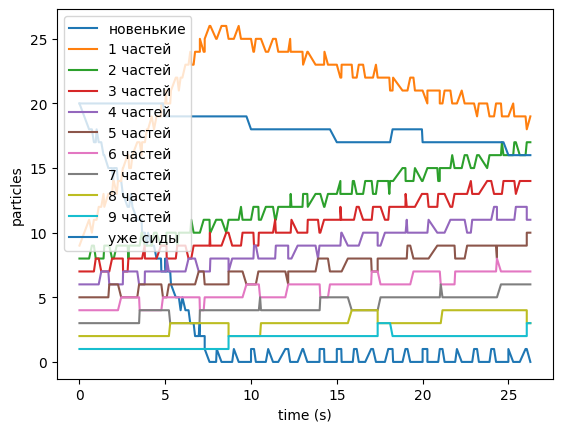

In [13]:
states = ["новенькие"] + [f"{i + 1} частей" for i in range(m - 1)] + ["уже сиды"]
def plot_particles_history(particles_history, times):
    for i in range(m + 1):
        plt.plot(times, particles_history[:, i], label=f"{states[i]}")
    plt.xlabel("time (s)")
    plt.ylabel("particles")
    plt.legend()
    plt.show()

plot_particles_history(particles_history, times)

In [14]:
alpha = get_alpha()

k = 400
trj = 1000
particles_history = np.empty((trj, k + 1, n))
times = np.empty((trj, k + 1))
particles_history[:, 0, :] = alpha
times[:, 0] = 0

for j in range(trj):
    alpha = get_alpha()

    phi = ([lmb] +
       [lichers_[i] * lichers[i] / delta for i in range(m)] +
       [mu])

    tau = np.array([0 for _ in range(l)], dtype=np.float32) # время следующего события i
    for i in range(l):
        tau[i] = inverse_exp(random.random(), phi[i])


    for i in range(1, k + 1):
        tau, next_event, delta_time = update_tau(tau)
        alpha, phi = taking_action(alpha, next_event)
        tau[next_event] = inverse_exp(random.random(), phi[next_event])
        particles_history[j, i, :] = alpha
        times[j, i] = delta_time + times[j, i - 1]
        #if j == 0 or j == 1 or j == 2:
            #print(f"after {i} step:")
            #print("tau:", tau, "\nphi:", phi, "\nalpha:", alpha, "\nevent:", next_event)

D:\PyCharmPrj\ML\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


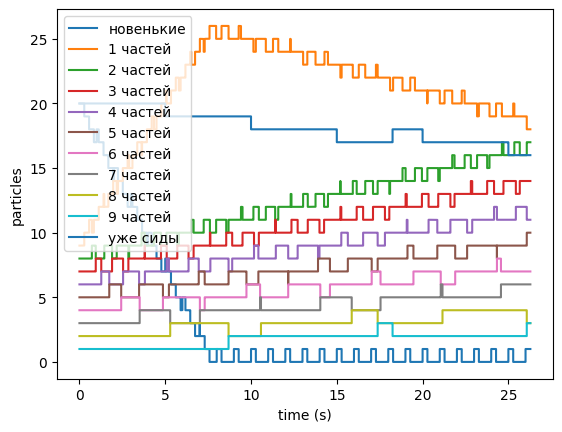

In [15]:
indices = np.ones(trj, dtype=int)
cum_indices = np.zeros(trj, dtype=int)
merged = [get_alpha()]
total_times = [0]

for i in range(trj * (k - 2)):
    idx_min = np.argmin(times[np.arange(trj), indices])
    cum_indices[idx_min] = min(cum_indices[idx_min] + 1, 200)
    indices[idx_min] = min(indices[idx_min] + 1, 200)

    merged.append(np.mean(particles_history[np.arange(trj), cum_indices, :], axis=0))
    total_times.append(times[idx_min, cum_indices[idx_min]])

merged = np.array(merged)[:, :m + 1]
plt.plot(total_times, merged, label=["новенькие"] + [f"{i + 1} частей" for i in range(m - 1)] + ["уже сиды"])
plt.xlabel("time (s)")
plt.ylabel("particles")
plt.legend()
plt.show()

In [ ]:
print(tau)
print(eps)
print(p_gamma)
print(alpha)